# Team Members


---


# Bishoy geroge 20217021

# Farah Mohamed 20216128

# Toka Abdelghafar 20218003

# Omar Ahmed 20216067

In [1]:
# Import necessary libraries
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from collections import defaultdict
import random
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Load Data

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

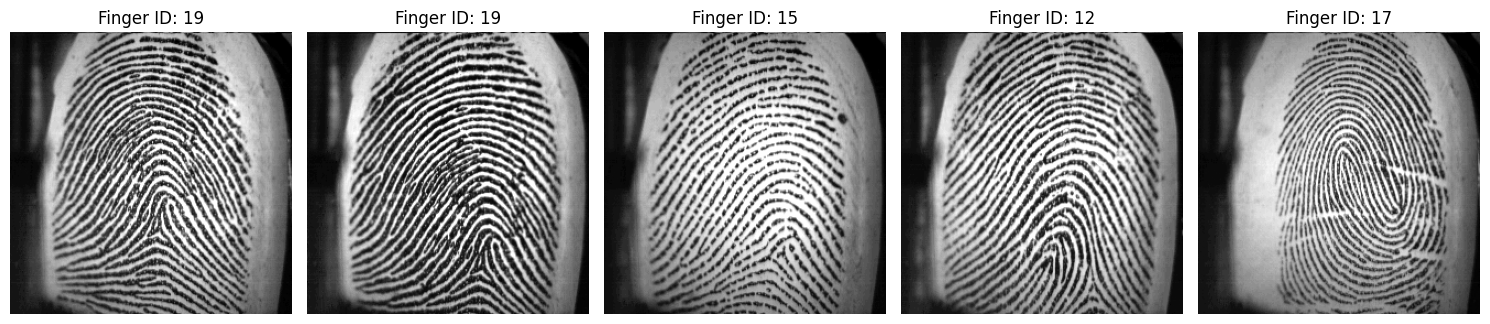

Loaded 168 raw fingerprint images
Number of unique fingers: 21
Raw image shape: (256, 256)


In [3]:
def load_raw_images():
    # Extract ZIP file
    zip_path = "fingerprint_bitmaps.zip"
    extract_folder = "fingerprints"

    if not os.path.exists(extract_folder):  # Avoid re-extraction if already done
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)

    # Get all image paths
    images = glob(os.path.join(extract_folder, "*.bmp"))

    raw_data, labels = [], []

    for img_path in images:
        filename = os.path.basename(img_path)

        try:
            finger_id = int(filename.split('_')[0])
        except ValueError:
            print(f"Skipping file: {filename} (Invalid format)")
            continue

        # Load image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Error loading image: {img_path}")
            continue

        # Append raw data
        raw_data.append(img)
        labels.append(finger_id)

    return raw_data, labels

# Load raw images
raw_data, labels = load_raw_images()

# Display some raw images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(raw_data[i], cmap='gray')
    plt.title(f"Finger ID: {labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Loaded {len(raw_data)} raw fingerprint images")
print(f"Number of unique fingers: {len(np.unique(labels))}")
print(f"Raw image shape: {raw_data[0].shape}")

### preprocessing

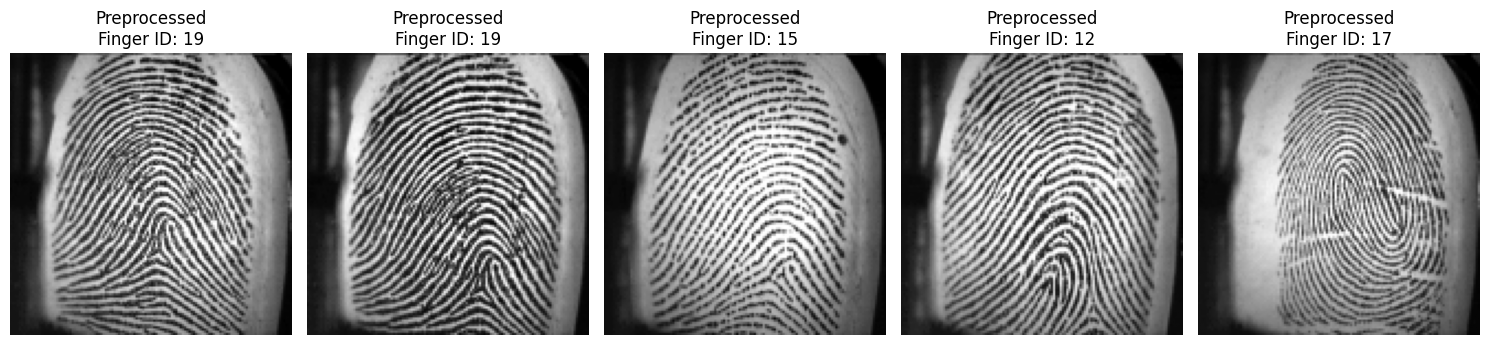

Preprocessed image shape: (128, 128, 1)
Original value range: [0, 255]
Preprocessed value range: [0.0000, 1.0000]


In [4]:
def preprocess_images(raw_images):
    processed_data = []

    for img in raw_images:
        # Resize to 128x128 pixels
        img_resized = cv2.resize(img, (128, 128))

        # Normalize pixel values to [0, 1]
        img_normalized = img_resized.astype(np.float32) / 255.0

        # Add channel dimension
        img_with_channel = np.expand_dims(img_normalized, axis=-1)

        processed_data.append(img_with_channel)

    # Convert to NumPy array
    X = np.array(processed_data)

    return X

# Preprocess images
X = preprocess_images(raw_data)
y = np.array(labels, dtype=np.int32)

# Display preprocessed images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[i].squeeze(), cmap='gray')
    plt.title(f"Preprocessed\nFinger ID: {y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Preprocessed image shape: {X.shape[1:]}")
print(f"Original value range: [{raw_data[0].min()}, {raw_data[0].max()}]")
print(f"Preprocessed value range: [{X[0].min():.4f}, {X[0].max():.4f}]")

### Generate a version of the dataset

Total pairs: 1176
Positive pairs (same finger): 588
Negative pairs (different fingers): 588


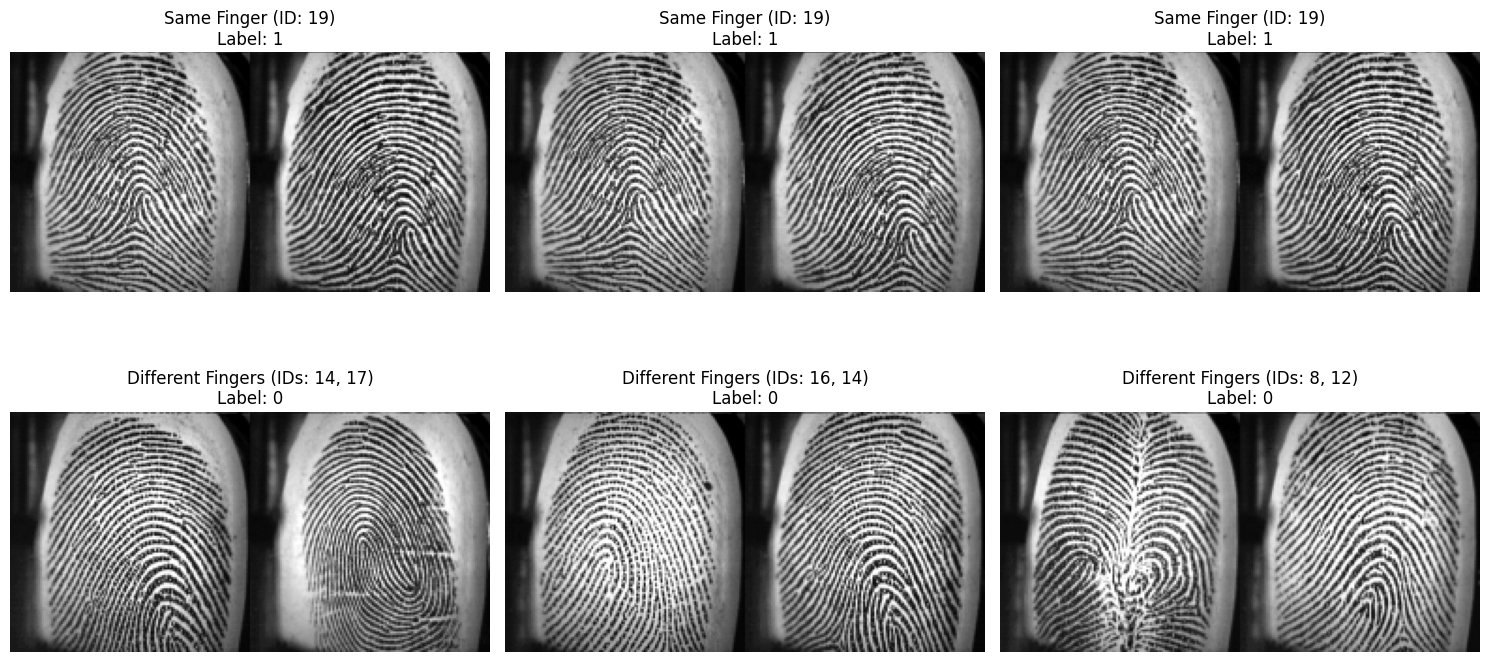

In [5]:
def create_pairs(images, labels):
    pairs, pair_indices, pair_labels = [], [], []
    finger_indices = defaultdict(list)

    # Map finger IDs to their image indices
    for idx, fid in enumerate(labels):
        finger_indices[fid].append(idx)

    # Generate positive pairs (same finger)
    for fid, indices in finger_indices.items():
        if len(indices) < 2:
            continue  # Skip fingers with only one impression

        for i in range(len(indices)):
            for j in range(i+1, len(indices)):
                pair_indices.append((indices[i], indices[j]))
                pairs.append([images[indices[i]], images[indices[j]]])
                pair_labels.append(1)  # 1 = same finger

    # Generate negative pairs (different fingers)
    num_pos = len(pair_labels)
    fingers = list(finger_indices.keys())

    neg_pairs_set = set()  # Track unique negative pairs

    while len(pair_labels) < 2 * num_pos:  # Create equal number of positive and negative pairs
        if len(fingers) < 2:
            break

        f1, f2 = random.sample(fingers, 2)
        i = random.choice(finger_indices[f1])
        j = random.choice(finger_indices[f2])

        pair_key = (min(i, j), max(i, j))
        if pair_key not in neg_pairs_set:
            neg_pairs_set.add(pair_key)
            pair_indices.append((i, j))
            pairs.append([images[i], images[j]])
            pair_labels.append(0)  # 0 = different fingers

    return np.array(pairs), np.array(pair_indices), np.array(pair_labels)

# Generate pairs
pairs, pair_indices, pair_labels = create_pairs(X, y)

print(f"Total pairs: {len(pairs)}")
print(f"Positive pairs (same finger): {np.sum(pair_labels)}")
print(f"Negative pairs (different fingers): {len(pair_labels) - np.sum(pair_labels)}")

# Display sample pairs
plt.figure(figsize=(15, 8))

# Display positive pairs (same finger)
for i in range(3):
    # Find a positive pair
    pos_idx = np.where(pair_labels == 1)[0][i]
    img1, img2 = pairs[pos_idx]
    idx1, idx2 = pair_indices[pos_idx]

    plt.subplot(2, 3, i+1)
    plt.imshow(np.hstack([img1.squeeze(), img2.squeeze()]), cmap='gray')
    plt.title(f"Same Finger (ID: {y[idx1]})\nLabel: 1")
    plt.axis('off')

# Display negative pairs (different fingers)
for i in range(3):
    # Find a negative pair
    neg_idx = np.where(pair_labels == 0)[0][i]
    img1, img2 = pairs[neg_idx]
    idx1, idx2 = pair_indices[neg_idx]

    plt.subplot(2, 3, i+4)
    plt.imshow(np.hstack([img1.squeeze(), img2.squeeze()]), cmap='gray')
    plt.title(f"Different Fingers (IDs: {y[idx1]}, {y[idx2]})\nLabel: 0")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Split Data

In [6]:
unique_fingers = np.unique(y)
train_fingers, test_fingers = train_test_split(unique_fingers, test_size=0.2, random_state=42)

# Create masks for train and test sets
train_mask = np.isin(y, train_fingers)
test_mask = np.isin(y, test_fingers)

# Split the image data
X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

# Generate pairs for training and testing
train_pairs, train_indices, train_labels = create_pairs(X_train, y_train)
test_pairs, test_indices, test_labels = create_pairs(X_test, y_test)

print(f"Training set: {len(X_train)} images, {len(train_pairs)} pairs")
print(f"Test set: {len(X_test)} images, {len(test_pairs)} pairs")
print(f"Training fingers: {len(train_fingers)}")
print(f"Test fingers: {len(test_fingers)}")

Training set: 128 images, 896 pairs
Test set: 40 images, 280 pairs
Training fingers: 16
Test fingers: 5


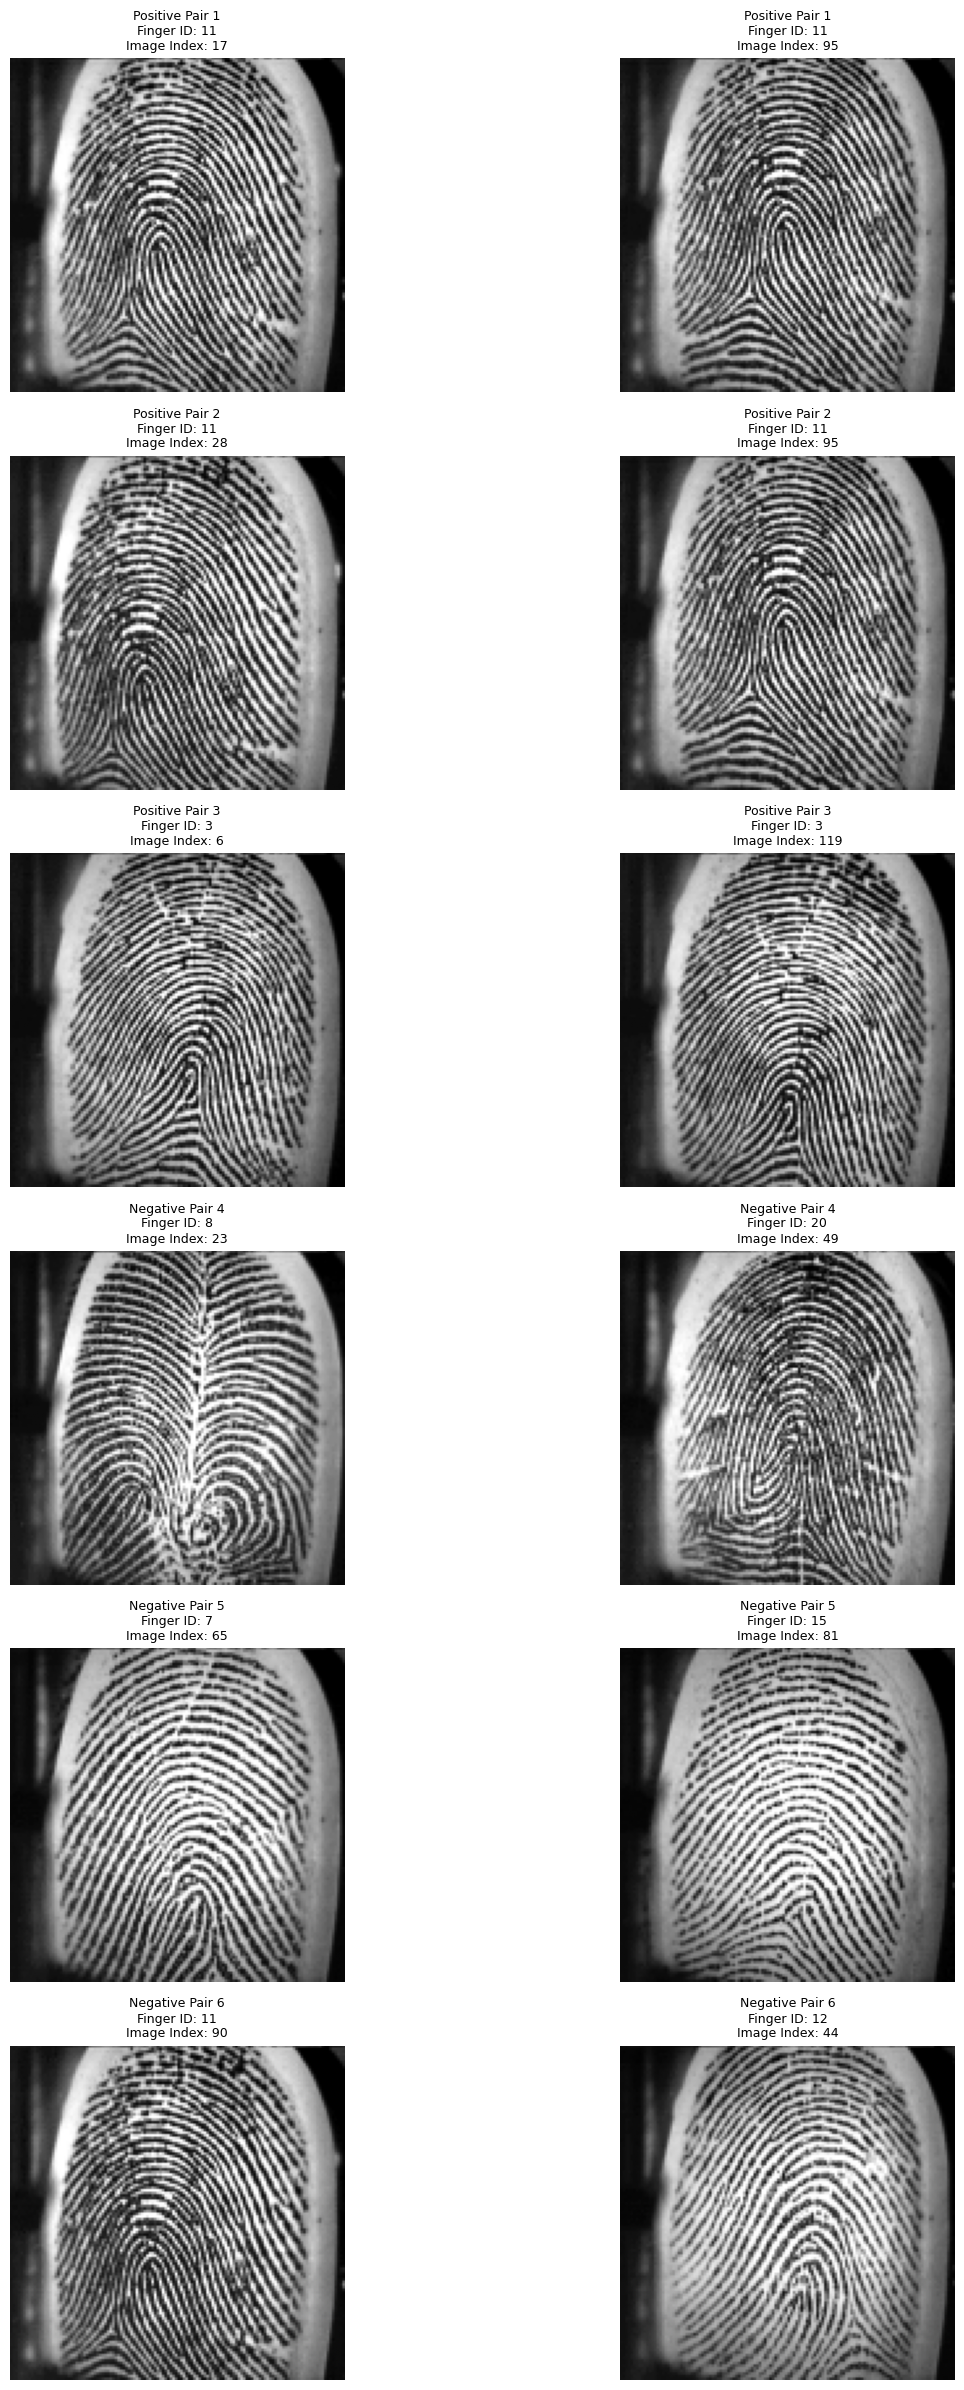

In [7]:
def visualize_pairs_with_ids(pairs, pair_indices, labels, y_original, num_pos=3, num_neg=3):
    # Separate positive and negative pairs
    pos_mask = labels == 1
    pos_pairs = pairs[pos_mask]
    pos_indices = pair_indices[pos_mask]
    neg_pairs = pairs[~pos_mask]
    neg_indices = pair_indices[~pos_mask]

    # Random selection
    selected_pos = np.random.choice(len(pos_pairs), num_pos, replace=False)
    selected_neg = np.random.choice(len(neg_pairs), num_neg, replace=False)

    plt.figure(figsize=(15, 4 * (num_pos + num_neg)))

    # Plot positive pairs
    for i, idx in enumerate(selected_pos):
        img1, img2 = pos_pairs[idx]
        idx1, idx2 = pos_indices[idx]

        plt.subplot(num_pos + num_neg, 2, 2*i+1)
        plt.imshow(img1.squeeze(), cmap='gray')
        plt.title(f"Positive Pair {i+1}\nFinger ID: {y_original[idx1]}\nImage Index: {idx1}", fontsize=9)
        plt.axis('off')

        plt.subplot(num_pos + num_neg, 2, 2*i+2)
        plt.imshow(img2.squeeze(), cmap='gray')
        plt.title(f"Positive Pair {i+1}\nFinger ID: {y_original[idx2]}\nImage Index: {idx2}", fontsize=9)
        plt.axis('off')

    # Plot negative pairs
    for j, idx in enumerate(selected_neg, start=num_pos):
        img1, img2 = neg_pairs[idx]
        idx1, idx2 = neg_indices[idx]

        plt.subplot(num_pos + num_neg, 2, 2*j+1)
        plt.imshow(img1.squeeze(), cmap='gray')
        plt.title(f"Negative Pair {j+1}\nFinger ID: {y_original[idx1]}\nImage Index: {idx1}", fontsize=9)
        plt.axis('off')

        plt.subplot(num_pos + num_neg, 2, 2*j+2)
        plt.imshow(img2.squeeze(), cmap='gray')
        plt.title(f"Negative Pair {j+1}\nFinger ID: {y_original[idx2]}\nImage Index: {idx2}", fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
visualize_pairs_with_ids(train_pairs, train_indices, train_labels, y_train)

# Siamese Network

###### Define the Base Model

In [8]:
def build_siamese_model(input_shape):
    # Define the base CNN for feature extraction
    def build_base_network(input_shape):
        inputs = layers.Input(shape=input_shape)

        # Block 1
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)

        # Block 2
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)

        # Block 3
        x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(0.25)(x)

        # Feature vector
        x = layers.Flatten()(x)
        x = layers.Dense(128, activation='relu')(x)

        return models.Model(inputs, x)

    # Build the twin networks
    base_network = build_base_network(input_shape)

    # Create the two inputs
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    # Process each input through the base network
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Calculate the L1 distance between the twin features
    distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([processed_a, processed_b])

    # Add a fully connected layer for final prediction
    prediction = layers.Dense(1, activation='sigmoid')(distance)

    # Create the model
    siamese_model = models.Model(inputs=[input_a, input_b], outputs=prediction)

    return siamese_model

# Create the model
input_shape = X_train.shape[1:]  # (128, 128, 1)
model = build_siamese_model(input_shape)

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Model summary
model.summary()

# Prepare data for training
train_pairs_a = train_pairs[:, 0]  # First image in each pair
train_pairs_b = train_pairs[:, 1]  # Second image in each pair
test_pairs_a = test_pairs[:, 0]
test_pairs_b = test_pairs[:, 1]

# Define callbacks to prevent overfitting
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 128)            │      4,288,000 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128)            │              0 │ functional[0][0],      │
│                           │                        │                │ functional[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            129 │ lambda[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,288,129 (16.36 MB)

 Trainable params: 4,287,681 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# Train the model
history = model.fit(
    [train_pairs_a, train_pairs_b],
    train_labels,
    validation_data=([test_pairs_a, test_pairs_b], test_labels),
    batch_size=32,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 116s 4s/step - accuracy: 0.5306 - loss: 1.1733 - val_accuracy: 0.4893 - val_loss: 0.6913 - learning_rate: 1.0000e-04
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.7632 - loss: 0.4928 - val_accuracy: 0.4964 - val_loss: 0.6861 - learning_rate: 1.0000e-04
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 138s 4s/step - accuracy: 0.8175 - loss: 0.4072 - val_accuracy: 0.5000 - val_loss: 0.6802 - learning_rate: 1.0000e-04
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.8513 - loss: 0.2956 - val_accuracy: 0.5000 - val_loss: 0.6749 - learning_rate: 1.0000e-04
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 167s 5s/step - accuracy: 0.9058 - loss: 0.2207 - val_accuracy: 0.4964 - val_loss: 0.6740 - learning_rate: 1.0000e-04
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.9072 - loss: 0.2053 - val_accuracy: 0.5107 - val_loss: 0.6773 - learning_rate: 1.0000e-04
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.9229 

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step
Test Accuracy: 0.7179
Precision: 0.8675
Recall: 0.5143
F1 Score: 0.6457
AUC-ROC: 0.9137


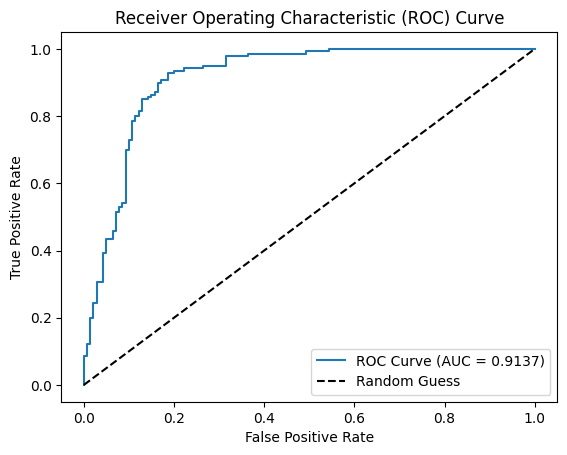

In [14]:
# ## 6. Evaluate the performance of the model on the test set using different metrics
# Get predictions on test set
y_pred_probs = model.predict([test_pairs_a, test_pairs_b])
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred)
auc = roc_auc_score(test_labels, y_pred_probs)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_probs)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 980ms/step


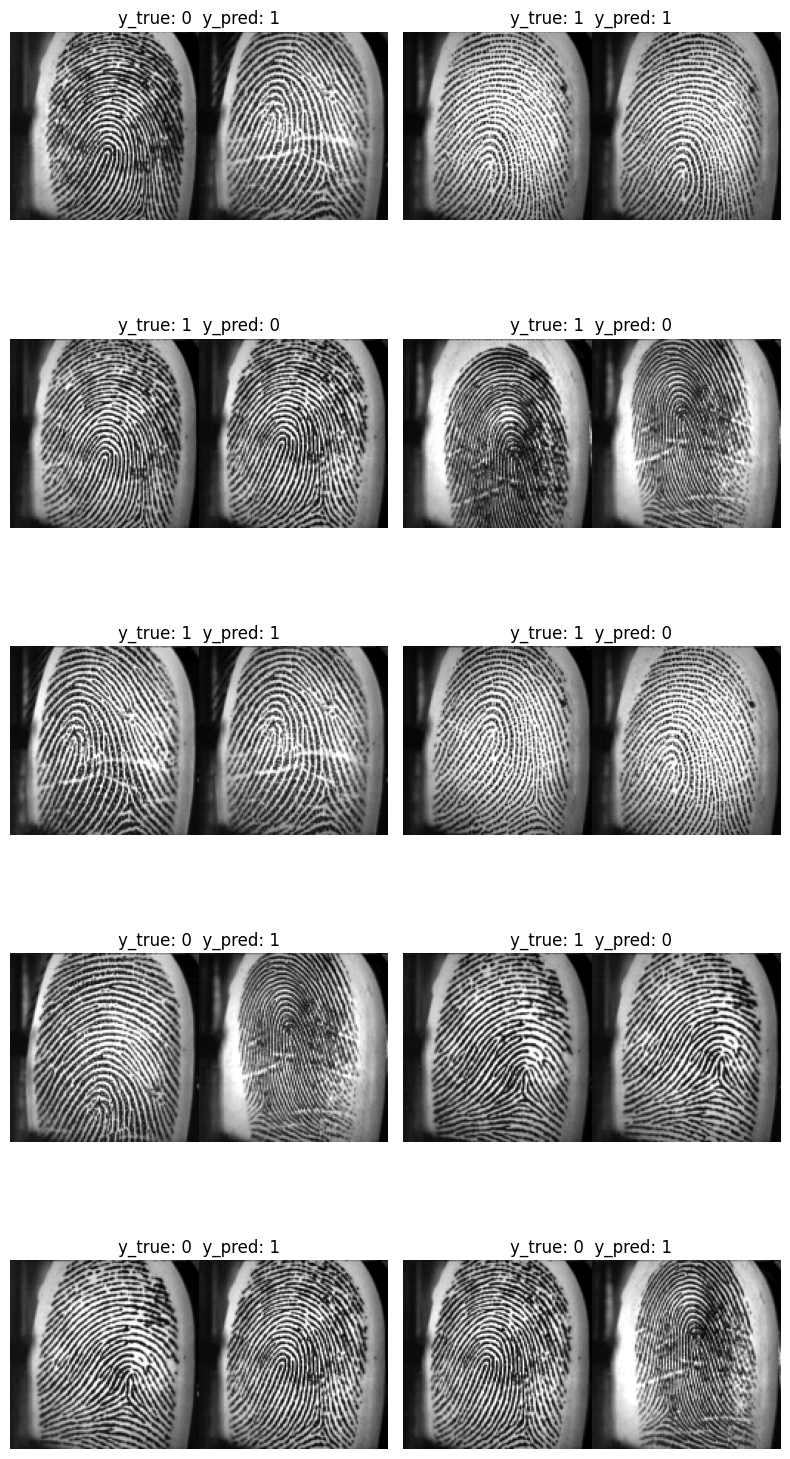

In [13]:
predictions = model.predict([test_pairs[:, 0], test_pairs[:, 1]])

# Plot results
fig, axes = plt.subplots(5, 2, figsize=(8, 16))  # 5 rows, 2 columns

for i in range(10):
    ax = axes[i // 2, i % 2]

    #Randomly select an image pair
    img_idx = random.randint(0, len(test_pairs) - 1)

    #Concatenate the two images for side-by-side comparison
    combined_img = np.concatenate([test_pairs[img_idx][0], test_pairs[img_idx][1]], axis=1)

    #Display image
    ax.imshow(combined_img, cmap='gray')

    #Set title with true label and predicted result
    true_label = test_labels[img_idx]  # Ensure you have the correct labels variable
    predicted_label = int(predictions[img_idx][0] < 0.5)  # Convert similarity score to 0 (No Match) or 1 (Match)
    ax.set_title(f"y_true: {true_label}  y_pred: {predicted_label}")

    ax.axis('off')  # Hide axes for cleaner visualization

plt.tight_layout()
plt.show()

## Genuine Authentication

Test authentication with two images from the same user

## Imposter Authentication

Test authentication with images from different users

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


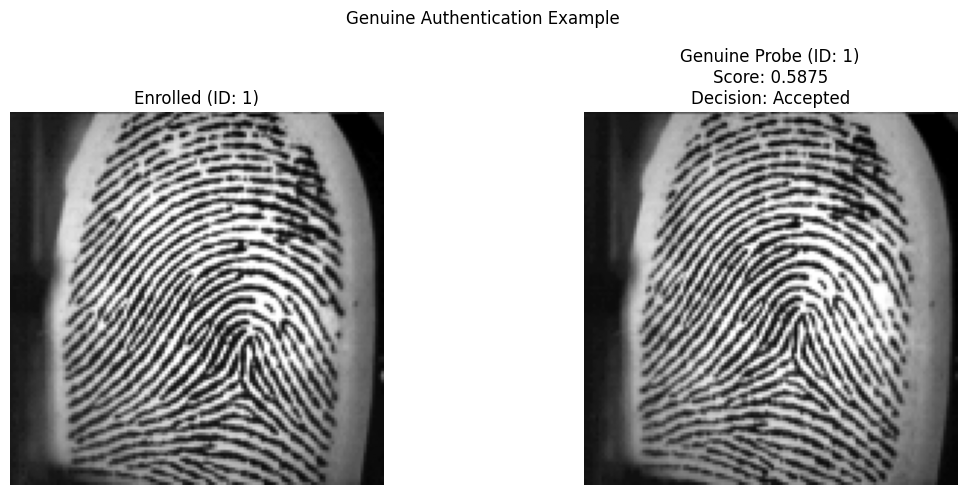

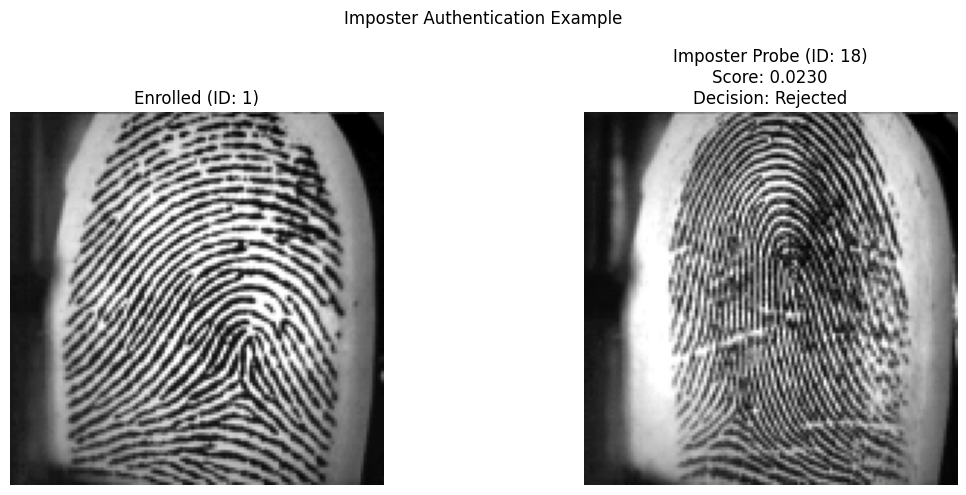

In [15]:
def authenticate_user(enrolled_img, probe_img, model, threshold=0.5):
    # Create pair and predict
    pair = np.array([[enrolled_img, probe_img]])
    score = model.predict([pair[:, 0], pair[:, 1]])[0][0]
    decision = "Accepted" if score >= threshold else "Rejected"
    return score, decision

# Find valid test users (with ≥2 images for genuine examples)
test_user_counts = np.bincount(y_test)
valid_genuine_users = [user for user in test_fingers if test_user_counts[user] >= 2]

if len(valid_genuine_users) == 0:
    print("No test users with multiple images available.")
else:
    # Example 1: Genuine authentication
    genuine_user = valid_genuine_users[0]
    genuine_indices = np.where(y_test == genuine_user)[0]
    enrolled_img = X_test[genuine_indices[0]]
    probe_img_genuine = X_test[genuine_indices[1]]

    score_genuine, decision_genuine = authenticate_user(enrolled_img, probe_img_genuine, model)

    # Example 2: Imposter authentication
    imposter_users = [user for user in test_fingers if user != genuine_user]
    if imposter_users:
        imposter_user = imposter_users[0]
        imposter_indices = np.where(y_test == imposter_user)[0]
        if len(imposter_indices) > 0:
            probe_img_imposter = X_test[imposter_indices[0]]
            score_imposter, decision_imposter = authenticate_user(enrolled_img, probe_img_imposter, model)

            # Plot results
            plt.figure(figsize=(12, 5))

            # Genuine example (compare two different impressions of the same finger)
            plt.subplot(1, 2, 1)
            plt.imshow(enrolled_img.squeeze(), cmap='gray')
            plt.title(f"Enrolled (ID: {genuine_user})")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(probe_img_genuine.squeeze(), cmap='gray')
            plt.title(f"Genuine Probe (ID: {genuine_user})\nScore: {score_genuine:.4f}\nDecision: {decision_genuine}")
            plt.axis('off')
            plt.suptitle("Genuine Authentication Example")
            plt.tight_layout()
            plt.show()

            # Imposter example (compare finger with another from a different user )
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(enrolled_img.squeeze(), cmap='gray')
            plt.title(f"Enrolled (ID: {genuine_user})")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(probe_img_imposter.squeeze(), cmap='gray')
            plt.title(f"Imposter Probe (ID: {imposter_user})\nScore: {score_imposter:.4f}\nDecision: {decision_imposter}")
            plt.axis('off')
            plt.suptitle("Imposter Authentication Example")
            plt.tight_layout()
            plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


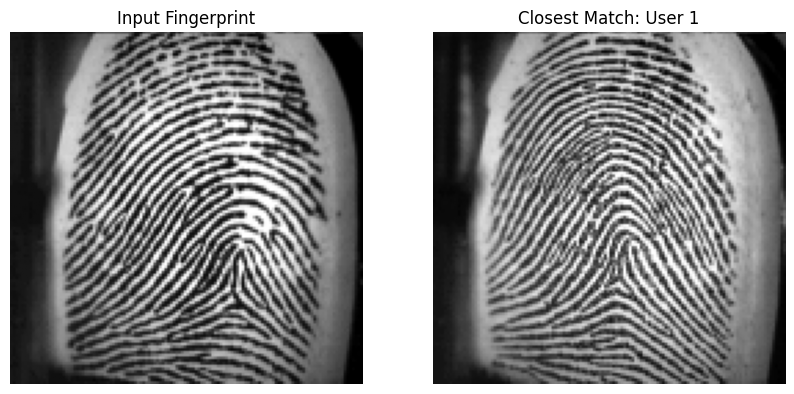

Identified as User 1 (Score: 0.2212)


In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def identify_fingerprint(fingerprint_path, stored_fingerprints, model, threshold=0.2):

    # Load and preprocess the input fingerprint
    img = cv2.imread(fingerprint_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return "Error: Unable to load fingerprint image."

    img_resized = cv2.resize(img, (128, 128))
    img_normalized = img_resized.astype(np.float32) / 255.0
    img_with_channel = np.expand_dims(img_normalized, axis=-1)

    best_match = None
    highest_score = 0

    # Compare with all users
    for user_id, stored_images in stored_fingerprints.items():
        test_pairs = np.array([[img_with_channel, stored_img] for stored_img in stored_images])

        test_pairs_a = test_pairs[:, 0]  # First image in each pair
        test_pairs_b = test_pairs[:, 1]  # Second image in each pair

        similarity_scores = model.predict([test_pairs_a, test_pairs_b])
        avg_score = np.mean(similarity_scores)

        # Find best match
        if avg_score > highest_score:
            highest_score = avg_score
            best_match = user_id

    # Decision: Accept or Reject
    if highest_score > threshold:
        result = f"Identified as User {best_match} (Score: {highest_score:.4f})"
    else:
        result = f"Fingerprint not recognized (Highest Score: {highest_score:.4f})"

    # Visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized, cmap='gray')
    plt.title("Input Fingerprint")
    plt.axis('off')

    if best_match:
        plt.subplot(1, 2, 2)
        plt.imshow(stored_fingerprints[best_match][0].squeeze(), cmap='gray')
        plt.title(f"Closest Match: User {best_match}")
        plt.axis('off')

    plt.show()

    return result


# Example Usage:
# Assume stored_fingerprints is a dictionary with stored fingerprint images for each user
stored_fingerprints = {
    1: [X_train[i] for i in range(3)],  # User 1 has 3 stored fingerprints
    2: [X_train[i+3] for i in range(3)],  # User 2 has 3 stored fingerprints
    3: [X_train[i+6] for i in range(3)],  # User 3 has 3 stored fingerprints
}

fingerprint_image_path = "/content/1_1.bmp"

result = identify_fingerprint(fingerprint_image_path, stored_fingerprints, model)
print(result)
